In [1]:
import madi 

In [2]:
import sys
import time
import madi
from madi.utils import file_utils
import numpy as np
import pandas as pd
from typing import Tuple, List, Dict
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold

from madi.datasets import gaussian_mixture_dataset
from madi.detectors.neg_sample_neural_net_detector import NegativeSamplingNeuralNetworkAD
from madi.detectors.isolation_forest_detector import IsolationForestAd
from madi.detectors.integrated_gradients_interpreter import IntegratedGradientsInterpreter
from madi.detectors.one_class_svm import OneClassSVMAd
from madi.detectors.neg_sample_random_forest import NegativeSamplingRandomForestAd

import tensorflow as tf
assert tf.version.VERSION > '2.1.0'

In [3]:
#@title Choose the data set
_RESOURCE_LOCATION = "madi.datasets.data"
data_source = "smart_buildings" #@param ["gaussian_mixture", "smart_buildings"]
ds = None

class InvalidDatasetError(ValueError):
    pass

if data_source == 'gaussian_mixture':
  contamination = 0.15

  ds = gaussian_mixture_dataset.GaussianMixtureDataset(
          n_dim=16,
          n_modes=2,
          n_pts_pos=8000,
          sample_ratio=contamination,
          upper_bound=3,
          lower_bound=-3)
  
  print('Loaded Gaussian mixture with 2 modes in 16 dimensions, with a sample size of %d.' %len(ds.sample))

elif data_source == 'smart_buildings':
  
  data_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599.csv")
  readme_file = file_utils.PackageResource(
      _RESOURCE_LOCATION, "anomaly_detection_sample_1577622599_README.md")
  ds = madi.datasets.smart_buildings_dataset.SmartBuildingsDataset(data_file, readme_file)
  print(ds.description)

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


print('Randomize the data, and split into training and test sample.')
split_ix = int(len(ds.sample) * 0.8)
training_sample = ds.sample.iloc[:split_ix]
test_sample = ds.sample.iloc[split_ix:]
print("\tTraining sample size: %d" %len(training_sample))
print("\tTest sample size: %d" %len(test_sample))

The Smart Buildings Anomaly Detection dataset consists of 60,425
 multidimensional, multimodal observations derived from 15
 Variable Air Volume (VAV) climate control devices collected over 14 days
 between October 8 and October 21, 2019, from a Google campus in the
 California Bay Area. In 1,921 (3.2%) anomalous observations, the devices
 are unable to maintain setpoint, and are of interest to facilities
 technicians. A setpoint is maintained when the zone air temperature
 remains above the zone air heating setpoint, and below the zone air
 cooling setpoint. On Mondays through Fridays, from 6:00 am to 10:00 pm
 local time, the devices operate in a comfort mode, with tight constraints
 between the heating and cooling setpoints. From 10:00 pm to 6:00 am, and
 on weekends the setpoints are wider to reduce energy consumption, and
 hence, there are comfort and eco operating modes. The data had seven
 numeric dimensions: zone air cooling temperature setpoint, zone air
 heating temperature s

In [4]:
#@title Reset Anomlay Detectors
ad_dict = {}
log_dir = "logs/nsnn2" #@param {type:"string"}

# Set up the logging directory.
!mkdir $log_dir

The syntax of the command is incorrect.


In [5]:

# Isolation Forest Parameters
iso_params = {}

# One-class SVM Parameters
ocsvm_params = {}

# Neg Sampling Random Forest Parameters
nsrf_params = {}

# Neg Sampling Neural Net Parameters
nsnn_params = {}


if data_source == 'gaussian_mixture':

    iso_params['n_estimators'] = 40
    iso_params['max_samples'] = 0.1
    iso_params['contamination'] = 0.05
    iso_params['max_features'] = 0.44

    ocsvm_params['kernel'] = 'rbf'
    ocsvm_params['shrinking'] = True
    ocsvm_params['nu'] = 0.04  # Contamination
    ocsvm_params['gamma'] = 'scale'
    ocsvm_params['coef0'] = 0.0

    nsrf_params['sample_ratio']=10.0
    nsrf_params['sample_delta']=0.05
    nsrf_params['num_estimators'] = 150
    nsrf_params['criterion'] = 'gini'
    nsrf_params['max_depth'] = 50
    nsrf_params['min_samples_split'] = 12
    nsrf_params['min_samples_leaf'] = 5
    nsrf_params['min_weight_fraction_leaf'] = 0.06
    nsrf_params['max_features'] = 0.3
    nsrf_params['sample_ratio'] = 2.0
    nsrf_params['sample_delta'] = 0.05

    nsnn_params['sample_ratio']=10.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=16
    nsnn_params['steps_per_epoch']=80
    nsnn_params['epochs']=180
    nsnn_params['dropout']=0.7
    nsnn_params['layer_width']=145
    nsnn_params['n_hidden_layers']=3

elif data_source == 'smart_buildings':

    iso_params['n_estimators'] = 100
    iso_params['max_samples'] = 0.01
    iso_params['contamination'] = 0.27
    iso_params['max_features'] = 0.7

    ocsvm_params['kernel'] = 'rbf'
    ocsvm_params['shrinking'] = True
    ocsvm_params['nu'] = 0.36  # Contamination
    ocsvm_params['gamma'] = 'scale'
    ocsvm_params['coef0'] = 0.0

    nsrf_params['sample_ratio']=21.00
    nsrf_params['sample_delta']=0.05
    nsrf_params['num_estimators'] = 150
    nsrf_params['criterion'] = 'gini'
    nsrf_params['max_depth'] = 50
    nsrf_params['min_samples_split'] = 10
    nsrf_params['min_samples_leaf'] = 5
    nsrf_params['min_weight_fraction_leaf'] = 0.06
    nsrf_params['max_features'] = 0.26

    nsnn_params['sample_ratio']=25.0
    nsnn_params['sample_delta']=0.05
    nsnn_params['batch_size']=32
    nsnn_params['steps_per_epoch']=16
    nsnn_params['epochs']=100
    nsnn_params['dropout']=0.85
    nsnn_params['layer_width']=150
    nsnn_params['n_hidden_layers']=2

else:
  raise InvalidDatasetError("You requested an invalid data set (%s)." %data_source)


In [6]:
#@title Add in Isolation Forest Anomaly Detector (iso)
ad_dict['iso'] =IsolationForestAd(n_estimators=iso_params['n_estimators'], 
                               max_samples=iso_params['max_samples'], 
                               contamination=iso_params['contamination'], 
                               max_features=iso_params['max_features'], 
                               bootstrap=False, n_jobs=None,
                               random_state=None, verbose=0)#  behaviour is omitted for  now

print('Anomaly Detectors: ', list(ad_dict))   

Anomaly Detectors:  ['iso']


In [7]:
#@title Add in One-Class SVM (oc-svm)
ad_dict['oc-svm'] = OneClassSVMAd(
    kernel=ocsvm_params['kernel'],
    degree=3,
    gamma=ocsvm_params['gamma'],
    coef0=ocsvm_params['coef0'],
    tol=0.001,
    nu=ocsvm_params['nu'],
    shrinking=ocsvm_params['shrinking'],
    cache_size=200,
    verbose=False,
    max_iter=-1)

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['iso', 'oc-svm']


In [8]:
#@title Add in Negative Sampling Random Forest (ns-rf)
ad_dict['ns-rf']= NegativeSamplingRandomForestAd(
        n_estimators=nsrf_params['num_estimators'],
        criterion=nsrf_params['criterion'],
        max_depth=nsrf_params['max_depth'],
        min_samples_split=nsrf_params['min_samples_split'],
        min_samples_leaf=nsrf_params['min_samples_leaf'],
        min_weight_fraction_leaf=nsrf_params['min_weight_fraction_leaf'],
        max_features=nsrf_params['max_features'],
        max_leaf_nodes=None,
        min_impurity_decrease=0.0,
        # min_impurity_split=None,
        bootstrap=True,
        oob_score=False,
        n_jobs=None,
        random_state=None,
        verbose=0,
        warm_start=False,
        class_weight=None,
        # sample_delta=nsrf_params['sample_delta'],
        # sample_ratio=nsrf_params['sample_ratio']
        )

print('Anomaly Detectors: ', list(ad_dict))

Sample delta assigned
Anomaly Detectors:  ['iso', 'oc-svm', 'ns-rf']


In [9]:
#@title Add in Negative Sampling Neural Net (ns-nn)
ad_dict['ns-nn'] = NegativeSamplingNeuralNetworkAD(
        sample_ratio=nsnn_params['sample_ratio'],
        sample_delta=nsnn_params['sample_delta'],
        batch_size=nsnn_params['batch_size'],
        steps_per_epoch=nsnn_params['steps_per_epoch'],
        epochs=nsnn_params['epochs'],
        dropout=nsnn_params['dropout'],
        layer_width=nsnn_params['layer_width'],
        n_hidden_layers=nsnn_params['n_hidden_layers'],
        log_dir=log_dir)

print('Anomaly Detectors: ', list(ad_dict))

Anomaly Detectors:  ['iso', 'oc-svm', 'ns-rf', 'ns-nn']


In [10]:
from madi.utils.evaluation_utils import compute_auc

In [11]:
# anomaly_detectors = ['iso', 'ns-nn','oc-svm']
# anomaly_detectors = ['oc-svm']

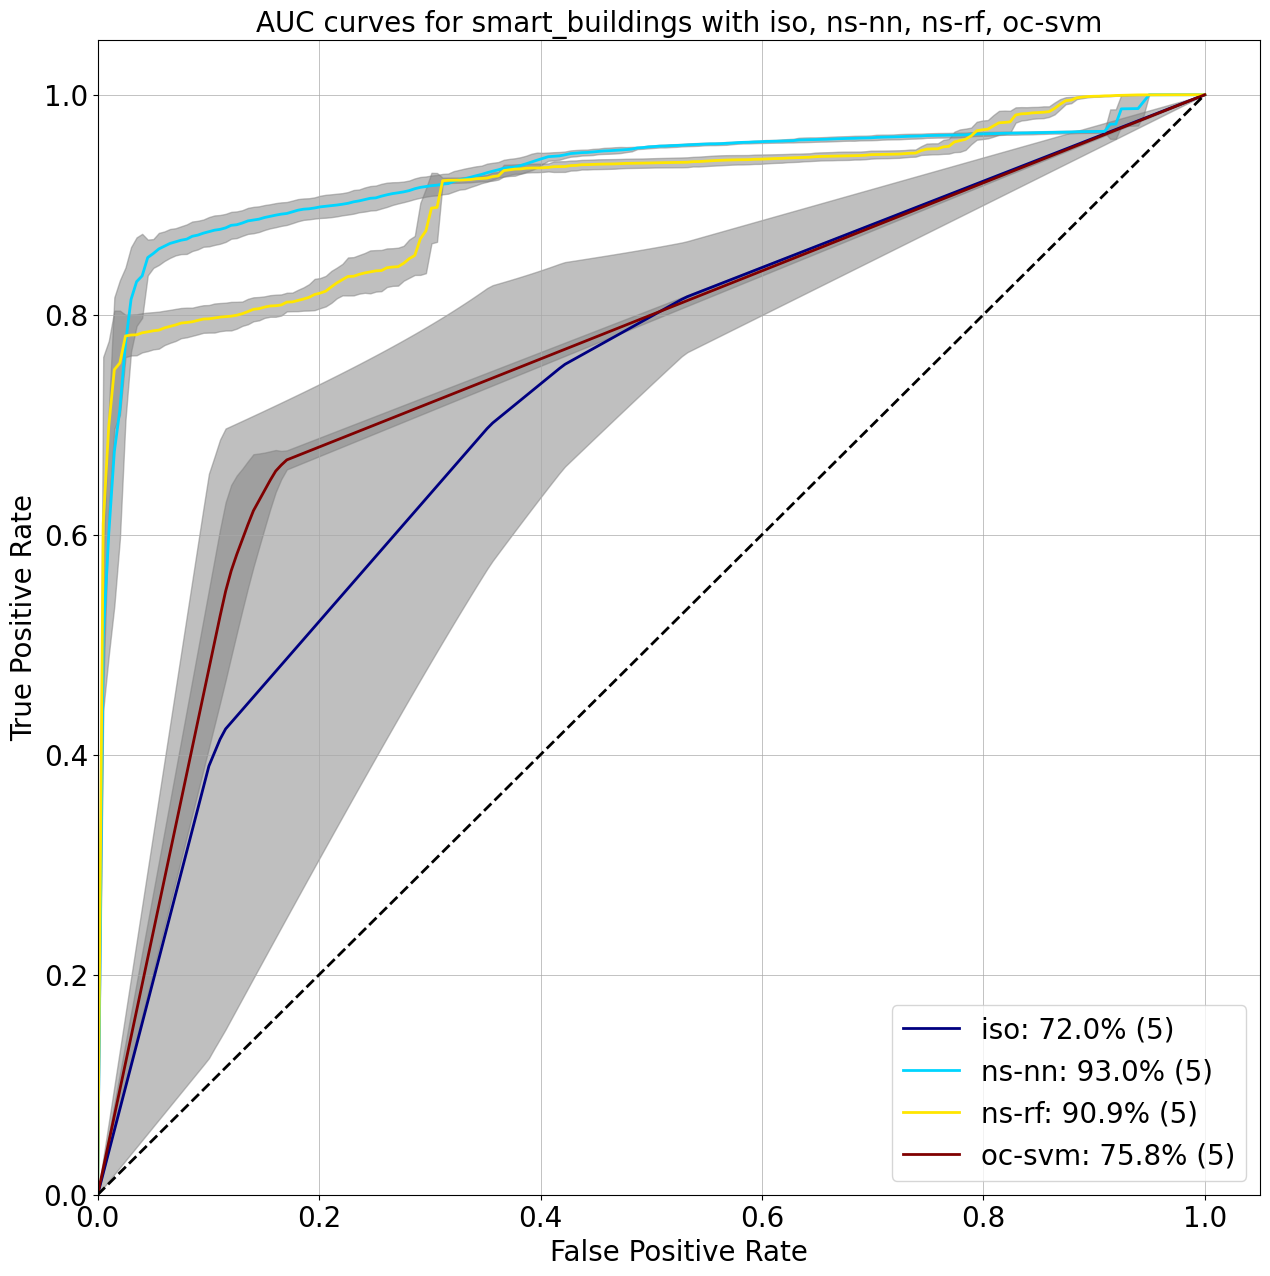

Final Results:
                   ad       auc     extime
000-00-iso        iso  0.659293   0.592000
000-01-iso        iso  0.816258   0.562074
000-02-iso        iso  0.603955   0.584002
000-03-iso        iso  0.691643   0.649134
000-04-iso        iso  0.830985   0.555006
000-00-ns-nn    ns-nn  0.923923   7.517211
000-01-ns-nn    ns-nn  0.932419   7.099133
000-02-ns-nn    ns-nn  0.937798   8.513781
000-03-ns-nn    ns-nn  0.923690   8.521514
000-04-ns-nn    ns-nn  0.932617   8.327201
000-00-ns-rf    ns-rf  0.920009  14.978582
000-01-ns-rf    ns-rf  0.912851  14.328915
000-02-ns-rf    ns-rf  0.904548  14.702379
000-03-ns-rf    ns-rf  0.904706  14.531369
000-04-ns-rf    ns-rf  0.904805  15.207165
000-00-oc-svm  oc-svm  0.743378  54.523540
000-01-oc-svm  oc-svm  0.747409  52.585593
000-02-oc-svm  oc-svm  0.768644  49.467779
000-03-oc-svm  oc-svm  0.769342  50.026624
000-04-oc-svm  oc-svm  0.759227  54.592092


In [12]:
#@title Execute Cross-Fold Validation {output-height:"unlimited"}
number_crossfolds =  1#@param {type:"integer"}
number_folds =  5#@param {type:"integer"}


def fold_sample(sample: pd.DataFrame, n_folds: int = 5) ->  List[Dict[str, pd.DataFrame]]:
  """Splits a sample into N folds.
  
  Args:
    sample: training/test sample to be folded.
  """
  sample = shuffle(sample)
  
  folds = []
  # Split into train and test folds, and assign to list called folds.
  for training_sample_idx, test_sample_idx in KFold(n_splits=5).split(sample):
    test_sample = sample.iloc[test_sample_idx]
    training_sample = sample.iloc[training_sample_idx]
    folds.append({"train": training_sample, "test": test_sample})
  return folds


def plot_auc(ad_results: Dict[str, Dict[str, Dict[str, np.array]]], 
             experiment_name: str):
  """Plots the ROC AUC. """
  
  fig, ax = plt.subplots(figsize=(15, 15))
  start = 0.0
  stop = 1.0
  colors = [cm.jet(x) for x in np.linspace(start, stop, len(ad_results))]

  df_auc = pd.DataFrame()

  lw = 2
  ix = 0
  for ad_id in ad_results:

    fold_results = ad_results[ad_id]
    vfprs = []
    vtprs = []

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 200)
    validation_aucs = []
    for fold_id in fold_results:
      fpr = fold_results[fold_id]['fpr']
      tpr = fold_results[fold_id]['tpr']

      validation_auc_val = auc(fpr, tpr)
      validation_aucs.append(validation_auc_val)    
      interp_tpr = np.interp(mean_fpr, fpr, tpr)
      interp_tpr[0] = 0.0
      tprs.append(interp_tpr)

    mean_tpr = np.mean(tprs, axis=0)
  
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(validation_aucs)
    df_auc[ad_id] = [mean_auc]

    plt.plot(mean_fpr, mean_tpr, color=colors[ix], lw=lw, 
             label='%s: %0.1f%% (%d)' % (
                 ad_id, 100.0 * mean_auc, len(fold_results) ))
    ix+=1

    std_tpr = np.std(tprs, axis=0)
    
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='gray', alpha=0.5,
                label=None)
    
  ax.grid(linestyle='-', linewidth='0.5', color='darkgray')
  plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.05])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('AUC curves for %s' %experiment_name)
  
  legend = plt.legend(loc='lower right', shadow=False, fontsize='20')
  legend.get_frame().set_facecolor('white')

  for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
  
  for sp in ax.spines:
    ax.spines[sp].set_color("black")

  plt.show()

anomaly_detectors = sorted(list(ad_dict))
experiment_name = "%s with %s" %(ds.name, ", ".join(anomaly_detectors))
# anomaly_detectors = ['iso', 'ns-nn', 'ns-rf']
df_results = pd.DataFrame(columns = ['ad', 'auc', 'extime'])
ad_results = {}

for ad in anomaly_detectors:
# for ad in ['iso', 'ns-nn','oc-svm']:

  if ad not in ad_results:
    ad_results[ad] = {}

  for cx_run in range(number_crossfolds):
    folds = fold_sample(ds.sample, n_folds = number_folds)

    for fid in range(number_folds):
      
      fold = folds[fid]

      # Drop the class label from the training sample, since this is unsupervised.
      training_sample = fold['train'].copy()
      testing_sample = fold['test'].copy()
      X_train = training_sample.drop(columns = ['class_label'])
      X_test  = testing_sample.drop(columns = ['class_label'])
      y_test  = testing_sample['class_label']

      start_time = time.time()

      # Train a model in the training split.
      ad_dict[ad].train_model(x_train=X_train)

      # Predict on the test set.
      y_predicted = ad_dict[ad].predict(X_test)['class_prob']

      # Compute the AUC on the test set. 
      # auc_value = madi.utils.evaluation_utils.compute_auc(
      #         y_actual=y_test, y_predicted=y_predicted)
      auc_value = compute_auc(y_actual=y_test, y_predicted=y_predicted)
        
      # Compute the ROC curve.
      fpr, tpr, _ = roc_curve(y_test, y_predicted)

      end_time = time.time()
      extime = end_time - start_time
      ad_results[ad]['%03d-%02d' %(cx_run, fid)] = {'fpr': fpr, 'tpr':tpr}
      df_results.loc['%03d-%02d-%s' %(cx_run, fid, ad)] = [ad, auc_value, extime]

      # Refresh the output area.
      clear_output()
      
      plot_auc(ad_results, experiment_name  = experiment_name)
      
      del training_sample
      del testing_sample
print("Final Results:")
print(df_results)

In [13]:
anomaly_detectors

['iso', 'ns-nn', 'ns-rf', 'oc-svm']